#Install Library

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import re
import glob

#Load Data

In [3]:
# Path ke folder di Google Drive
train_path = '/content/drive/MyDrive/BDM/finalproject bddm/dataset/AutismDataset/train'
test_path = '/content/drive/MyDrive/BDM/finalproject bddm/dataset/AutismDataset/test'

img_size = (224, 224)
batch_size = 32

#Data Preprocessing

In [4]:
# Fungsi untuk mendapatkan daftar file gambar dari sebuah path
def get_clean_image_names(path):
    # Dapatkan semua file dari path
    file_names = os.listdir(path)

    # Filter hanya file gambar
    image_files = [file for file in file_names if file.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

    # Hapus bagian yang tidak diinginkan dari nama file
    clean_names = [re.sub(r'\.\d+\.\w+$', '', file) for file in image_files]

    return clean_names

# Gabungkan daftar file gambar dari kedua path
train_names = get_clean_image_names(train_path)
test_names = get_clean_image_names(test_path)

In [5]:
import glob

def get_image_paths(path):
    # Menggunakan glob untuk mencocokkan file gambar dengan ekstensi tertentu
    return glob.glob(os.path.join(path, "*.[pP][nN][gG]")) + \
           glob.glob(os.path.join(path, "*.[jJ][pP][gG]")) + \
           glob.glob(os.path.join(path, "*.[jJ][pP][eE][gG]")) + \
           glob.glob(os.path.join(path, "*.[bB][mM][pP]")) + \
           glob.glob(os.path.join(path, "*.[gG][iI][fF]"))

# Dapatkan daftar path dari kedua direktori
image_train_path_list = get_image_paths(train_path)
image_test_path_list = get_image_paths(test_path)


In [6]:
train_df = pd.DataFrame({'image_path': image_train_path_list, 'label': train_names})
train_df.head()

,image_path,label
0,/content/drive/MyDrive/BDM/finalproject bddm/d...,Non_Autistic
1,/content/drive/MyDrive/BDM/finalproject bddm/d...,Non_Autistic
2,/content/drive/MyDrive/BDM/finalproject bddm/d...,Non_Autistic
3,/content/drive/MyDrive/BDM/finalproject bddm/d...,Non_Autistic
4,/content/drive/MyDrive/BDM/finalproject bddm/d...,Non_Autistic


In [7]:
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

In [8]:
test_df = pd.DataFrame({'image_path': image_test_path_list, 'label': test_names})
test_df.head()

,image_path,label
0,/content/drive/MyDrive/BDM/finalproject bddm/d...,Autistic
1,/content/drive/MyDrive/BDM/finalproject bddm/d...,Autistic
2,/content/drive/MyDrive/BDM/finalproject bddm/d...,Autistic
3,/content/drive/MyDrive/BDM/finalproject bddm/d...,Autistic
4,/content/drive/MyDrive/BDM/finalproject bddm/d...,Autistic


#Exploratory Data Analysis

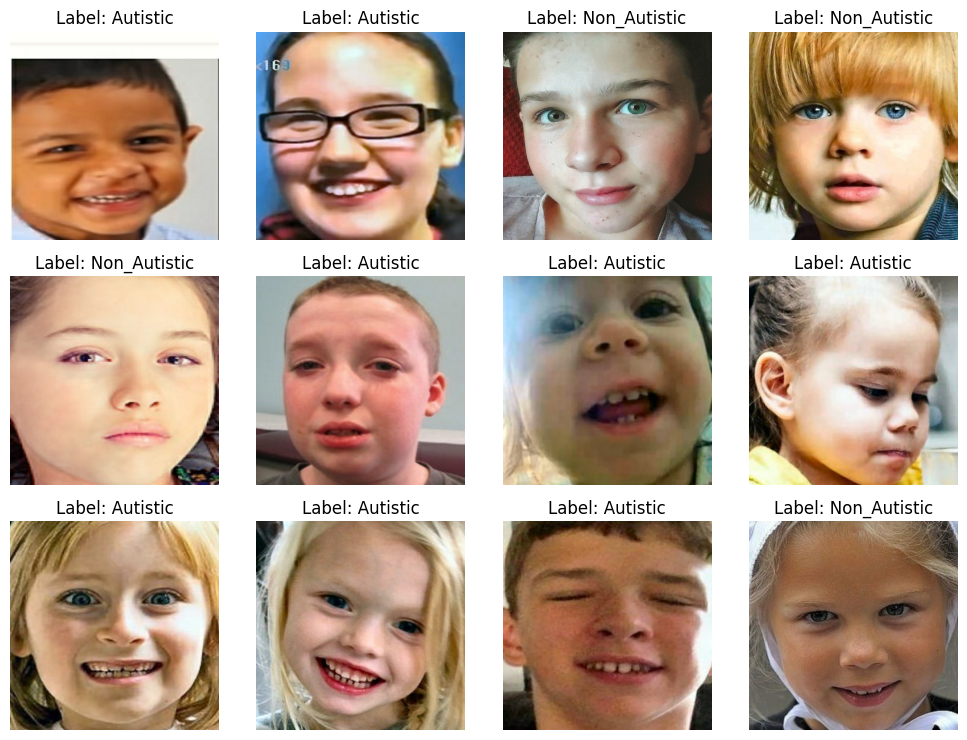

In [9]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd

# Define the function to load and preprocess the images
def load_image_and_label(image_path, label):
    # Load the image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Decode JPEG images into tensors
    image = tf.image.resize(image, [512, 512])  # Resize the images to a uniform size (e.g., 512x512)
    image = image / 255.0  # Normalize pixel values to [0, 1]

    return image, label

# Define a function to load and display images with labels
def display_image_grid_with_labels(image_paths, labels, load_image_fn, grid_size=(4, 4)):
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(10, 10 * grid_size[0] / grid_size[1]))

    # Loop over each subplot and display the image
    for i, (img_path, label, ax) in enumerate(zip(image_paths, labels, axes.flat)):
        # Load the image and label
        image, label = load_image_fn(img_path, label)

        # Convert the image tensor to a numpy array and display it
        ax.imshow(image.numpy())
        ax.set_title(f"Label: {label}")  # Display the label as title
        ax.axis('off')  # Turn off axes

    plt.tight_layout()
    plt.show()

# Sample 12 random images from train_df
sample_images = train_df.sample(12, random_state=50)

# Get the image paths and labels from the sampled dataframe
sample_image_paths = sample_images['image_path'].values
sample_labels = sample_images['label'].values

# Display the images with their labels in a 3x4 grid
display_image_grid_with_labels(sample_image_paths, sample_labels, load_image_and_label, grid_size=(3, 4))


#Seleksi Fitur

In [10]:
# Data Augmentation and Generators
datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [11]:
def create_generator(df):
    return datagen.flow_from_dataframe(
        dataframe=df,
        x_col='image_path',
        y_col='label',
        target_size=img_size,
        batch_size=batch_size,
        class_mode='binary'
    )

train_generator = create_generator(train_df)
val_generator = create_generator(val_df)

Found 2032 validated image filenames belonging to 2 classes.
Found 508 validated image filenames belonging to 2 classes.


#Modeling

In [12]:
# CNN Base Model (Feature Extractor)
cnn_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
cnn_base.trainable = False

In [13]:
# Transformer Encoder
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = models.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def build(self, input_shape):
        self.built = True

    def call(self, inputs, training=None):
        # Expand dimensions to simulate tokenization process
        inputs_expanded = tf.expand_dims(inputs, axis=1)
        attn_output = self.att(inputs_expanded, inputs_expanded, training=training)
        attn_output = tf.squeeze(attn_output, axis=1)  # Restore original dimensions
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Build Model
inputs = Input(shape=(224, 224, 3))
x = cnn_base(inputs, training=False)
x = GlobalAveragePooling2D()(x)

In [14]:
# Transformer Block
embed_dim = 512  # Embedding size for each token
num_heads = 8  # Number of attention heads
ff_dim = 512  # Hidden layer size in feed-forward network inside transformer

transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = Dense(embed_dim)(x)
x = transformer_block(x)
x = Dropout(0.2)(x)
# Output Layer
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


In [15]:
model = Model(inputs, outputs)

# Compile Model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [21]:
# Train Model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)



Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 48s 678ms/step - accuracy: 0.7604 - loss: 0.5121 - val_accuracy: 0.7559 - val_loss: 0.5014
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 45s 656ms/step - accuracy: 0.7649 - loss: 0.4893 - val_accuracy: 0.7382 - val_loss: 0.4998
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 43s 626ms/step - accuracy: 0.7873 - loss: 0.4730 - val_accuracy: 0.7402 - val_loss: 0.5501
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 82s 624ms/step - accuracy: 0.7527 - loss: 0.5159 - val_accuracy: 0.7343 - val_loss: 0.5076
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 45s 651ms/step - accuracy: 0.7595 - loss: 0.4887 - val_accuracy: 0.7598 - val_loss: 0.4880
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 43s 620ms/step - accuracy: 0.7548 - loss: 0.4888 - val_accuracy: 0.7736 - val_loss: 0.5132
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 82s 616ms/step - accuracy: 0.7846 - loss: 0.4659 - val_accuracy: 0.7343 - val_loss: 0.5116
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 82s 611ms/step - accuracy: 0.7776 - loss: 0.4682 - val_accu

In [26]:
# Save Model
model.save("autism_cnn_transformer_model.h5")

#Evaluasi Model

In [27]:
# Evaluasi Model pada Data Uji
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Generator untuk data uji
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='label',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # Jangan acak agar prediksi sesuai dengan urutan data uji
)
# Evaluasi model pada data uji
test_loss, test_accuracy = model.evaluate(test_generator)

print(f"Loss pada data uji: {test_loss:.4f}")
print(f"Akurasi pada data uji: {test_accuracy:.4f}")


Found 300 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.8479 - loss: 0.3542
Loss pada data uji: 0.4413
Akurasi pada data uji: 0.8067


In [24]:
# Prediksi pada data uji
y_pred = model.predict(test_generator)
y_pred_binary = (y_pred > 0.5).astype(int)  # Mengonversi probabilitas ke label biner

# Mengambil label asli
y_true = test_generator.classes

# Laporan Klasifikasi
from sklearn.metrics import classification_report, confusion_matrix
print("Laporan Klasifikasi:")
print(classification_report(y_true, y_pred_binary, target_names=test_generator.class_indices.keys()))

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step
Laporan Klasifikasi:
              precision    recall  f1-score   support

    Autistic       0.77      0.87      0.82       150
Non_Autistic       0.85      0.74      0.79       150

    accuracy                           0.81       300
   macro avg       0.81      0.81      0.81       300
weighted avg       0.81      0.81      0.81       300



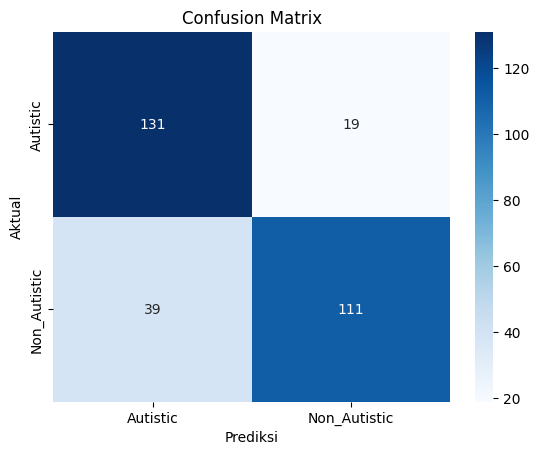

In [25]:
# Matriks Kebingungan
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title('Confusion Matrix')
plt.show()

#Kesimpulan